In [1]:
# Analytical Tools
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# General Utilities
import math
import json
import pprint
import itertools
import importlib

# Some settings
from IPython.display import Markdown, display
log = pprint.pprint
space = lambda: print()
printmd = lambda text: display(Markdown(text))
%matplotlib inline

def set_pandas_display_options() -> None:
    """Set pandas display options."""
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = 1000
    # display.precision = 2  # set as needed

set_pandas_display_options()

In [2]:
non_insight = ['What day follows the day before yesterday if two days from now will be Sunday?',
'Ben spent $42 for shoes. This was $14 less than what he spent for a shirt and twice more expensive than the tie. The tie was $20 cheaper than the jeans. How much was the jeans?',
'Next week I am going to have lunch with my friend, visit the new art gallery, go to the Social Security office, and have my teeth checked at the dentist. My friend cannot meet me on Wednesday; the Social Security office is closed weekends; the dentist has office hours only on Tuesday, Friday, and Saturday; the art gallery is closed Tuesday, Thursday, and weekends. On what single day can I do everything I have planned?',
'A group of soldiers were standing facing west. Their sergeant shouted at them: Right turn! U-turn! Left turn! U-turn! Right turn! U-turn! Left turn! Right turn! In which direction are they now facing?',
'The following verse spells out a word. I am a food for you and me. My first letter is in pat but not in tar. My second letter is in stream but not in smart. My third letter is in giraffe but not in fridge. My fourth letter is in treat but not in absent. What is the word that this verse described?'];

insight = ['A man is reading a book when the lights go off but even although the room is pitch dark the man goes on reading. How?',
'Alex and Casey are blood relatives of Bobbie. However, Alex and Casey are not blood relatives at all. How is this possible?',
'Mr. Hardy slipped and fell off a sixty-foot ladder onto the concrete floor below. However, he did not injure himself in any way. How is this possible?',
'Sid Shady was working for a large construction company that was very concerned about employee theft. Someone tipped company security that Shady was the man to watch. Each night, he passed through security with a wheelbarrow full of scrap lumber, discarded electrical wires, and chunks of concrete. The security guards checked the contents daily, but could find nothing of value. What was Shady stealing?',
'Joe Fan has no psychic powers but he can tell you the score of any football game before it starts. How?'];
 
anagram = ['Solve this anagram: NCRBOA', 
						'Solve this anagram: AYKAWLJ', 
						'Solve this anagram: EVANG',
						'Solve this anagram: MARNOD',
						'Solve this anagram: AALRYS']

In [3]:
with open('pilot1.json') as json_file:
    data = json.load(json_file)    
    

In [4]:
questions_non_insight = []
answers_non_insight = []
confidence_non_insight = []
difficulty_non_insight = []
aha_non_insight = []
rts_non_insight = []
close_non_insight = []

questions_insight = []
answers_insight = []
confidence_insight = []
difficulty_insight = []
aha_insight = []
rts_insight = []
close_insight = []

questions_anagram = []
answers_anagram = []
confidence_anagram = []
difficulty_anagram = []
aha_anagram = []
rts_anagram = []
close_anagram = []

for i in range(len(data)): #go thru the subjects
    if len(data[i]['data']) > 3: #only look at subjects that finished the task (and not just started without finishing)
        if int(data[i]['data'][3]['responses'][7]) == 3: #passed attention/quiz check, hooray!
            
            k = 5
            for j in range(3):
                question = data[i]['data'][0]['problems_seen'][j] #store the question seen by the participant
                answer = data[i]['data'][k]['responses']
                rt = 0 
                close = []

                while True:
                    answer = data[i]['data'][k]['responses']
                    k = k+1
                    close.append(int(data[i]['data'][k]['response']))
                    if 'done' not in answer.lower() and 'skip' not in answer.lower():
                        rt = rt+12
                        k = k+1
                    else:
                        rt = rt + data[i]['data'][k]['rt']/1000
                        k = k+1
                        break

                response = data[i]['data'][k]['responses'] #store people's responses to the questions here
                k = k+2 #move to the next question
                
                if question in non_insight:   
                    questions_non_insight.append(question)
                    answers_non_insight.append(answer)
                    rts_non_insight.append(rt)
                    confidence_non_insight.append(int(response[6])+1)
                    difficulty_non_insight.append(int(response[13])+1)
                    aha_non_insight.append(int(response[20])+1)
                    close_non_insight.append(close)
                    
                elif question in insight:
                    questions_insight.append(question)
                    answers_insight.append(answer)
                    rts_insight.append(rt)
                    confidence_insight.append(int(response[6])+1)
                    difficulty_insight.append(int(response[13])+1)
                    aha_insight.append(int(response[20])+1)
                    close_insight.append(close)

                elif question in anagram:
                    questions_anagram.append(question)
                    answers_anagram.append(answer)
                    rts_anagram.append(rt)
                    confidence_anagram.append(int(response[6])+1)
                    difficulty_anagram.append(int(response[13])+1)
                    aha_anagram.append(int(response[20])+1)
                    close_anagram.append(close)
        else:
            print(i)
            print('bad subject!')

44
bad subject!
65
bad subject!


Convert data into df

In [5]:
d = {'questions':questions_non_insight,
     'answers':answers_non_insight, 
     'rts': rts_non_insight,
     'confidence': confidence_non_insight, 
     'difficulty': difficulty_non_insight, 
     'aha': aha_non_insight,
     'close': close_non_insight}

d2 = {'questions':questions_insight,
     'answers':answers_insight, 
      'rts': rts_insight,
     'confidence': confidence_insight, 
     'difficulty': difficulty_insight, 
     'aha': aha_insight,
     'close': close_insight}

d3 = {'questions':questions_anagram,
     'answers':answers_anagram, 
     'rts': rts_anagram,
     'confidence': confidence_anagram, 
     'difficulty': difficulty_anagram, 
     'aha': aha_anagram,
     'close': close_anagram}

df_non_insight = pd.DataFrame(d)
df_insight = pd.DataFrame(d2)
df_anagram = pd.DataFrame(d3)

#Analyze only those responses for which people's confidence is greater than 5 and who said DONE (not SKIP)
df_non_insight_filtered = df_non_insight.loc[(df_non_insight['confidence'] >= 4) & (df_non_insight['answers'].str.contains("done", case=False))]
df_insight_filtered = df_insight.loc[(df_insight['confidence'] >= 4) & (df_insight['answers'].str.contains("done", case=False))]
df_anagram_filtered = df_anagram.loc[(df_anagram['confidence'] >= 4) & (df_anagram['answers'].str.contains("done", case=False))]

print(len(df_non_insight.index), len(df_non_insight_filtered.index))
print(len(df_insight.index), len(df_insight_filtered.index))
print(len(df_anagram.index), len(df_anagram_filtered.index))

37 29
37 22
37 24


In [6]:
df1 = df_anagram_filtered.groupby(['questions'], as_index=False).agg(['mean', 'count'])
df1

rts       confidence       difficulty        aha      
                                  mean count       mean count       mean count mean count
questions                                                                                
Solve this anagram: AALRYS   39.718900     1       6.00     1   2.000000     1  6.0     1
Solve this anagram: AYKAWLJ  31.537080     5       7.00     5   4.200000     5  4.8     5
Solve this anagram: EVANG    63.642225     8       6.25     8   3.625000     8  6.0     8
Solve this anagram: MARNOD   29.679600     4       6.75     4   2.500000     4  6.5     4
Solve this anagram: NCRBOA   54.656933     6       7.00     6   3.666667     6  6.0     6

In [7]:
df1 = df_non_insight_filtered.groupby(['questions', 'answers'], as_index=False).agg(['mean', 'count'])
df2 = df_insight_filtered.groupby(['questions', 'answers'], as_index=False).agg(['mean', 'count'])
df3 = df_anagram_filtered.groupby(['questions'], as_index=False).agg(['mean', 'count'])
df2

rts       confidence       difficulty             aha      
                                                                                                                                                                                                                            mean count       mean count       mean count      mean count
questions                                                                                                                                                                                               answers                                                                         
A man is reading a book when the lights go off but even although the room is pitch dark the man goes on reading. How?                                                                                   {"Q0":"DONE"}  28.981450     2   4.000000     2   5.000000     2  2.500000     2
                                                                                                                                                                                                        {"Q0":"Done"}  74.954100     1   6.000000     1   4.000000     1  5.000000     1
Alex and Casey are blood relatives of Bobbie. However, Alex and Casey are not blood relatives at all. How is this possible?                                                                             {"Q0":"DONE"}  21.117700     2   7.000000     2   1.500000     2  3.500000     2
                                                                                                                                                                                                        {"Q0":"Done"}   8.310700     2   6.000000     2   3.000000     2  5.500000     2
Joe Fan has no psychic powers but he can tell you the score of any football game before it starts. How?                                                                                                 {"Q0":"DONE"}  11.172107     3   5.666667     3   3.666667     3  5.333333     3
                                                                                                                                                                                                        {"Q0":"done"}  23.194433     3   6.333333     3   4.333333     3  4.666667     3
Mr. Hardy slipped and fell off a sixty-foot ladder onto the concrete floor below. However, he did not injure himself in any way. How is this possible?                                                  {"Q0":"DONE"}  22.833967     3   5.333333     3   2.666667     3  4.666667     3
                                                                                                                                                                                                        {"Q0":"Done"}   3.305000     1   7.000000     1   1.000000     1  5.000000     1
Sid Shady was working for a large construction company that was very concerned about employee theft. Someone tipped company security that Shady was the man to watch. Each night, he passed through ... {"Q0":"DONE"}  44.763950     4   5.000000     4   3.500000     4  3.500000     4
                                                                                                                                                                                                        {"Q0":"done"}  50.395000     1   6.000000     1   4.000000     1  2.000000     1

In [10]:
df1 = df_non_insight_filtered.groupby(['questions', 'answers'], as_index=False).agg(['mean', 'count'])
df2 = df_insight_filtered.groupby(['questions', 'answers'], as_index=False).agg(['mean', 'count'])
df3 = df_anagram_filtered.groupby(['questions'], as_index=False).agg(['mean', 'count'])
df1

rts       confidence       difficulty             aha      
                                                                                                                                                                                                                             mean count       mean count       mean count      mean count
questions                                                                                                                                                                                               answers                                                                          
A group of soldiers were standing facing west. Their sergeant shouted at them: Right turn! U-turn! Left turn! U-turn! Right turn! U-turn! Left turn! Right turn! In which direction are they now fac... {"Q0":"DONE"}   31.622900     3   6.666667     3   3.000000     3  1.000000     3
Ben spent $42 for shoes. This was $14 less than what he spent for a shirt and twice more expensive than the tie. The tie was $20 cheaper than the jeans. How much was the jeans?                        {"Q0":"DONE"}   42.743100     3   6.000000     3   3.000000     3  1.666667     3
                                                                                                                                                                                                        {"Q0":"Done"}   65.609750     2   6.500000     2   4.000000     2  3.500000     2
                                                                                                                                                                                                        {"Q0":"done"}   38.374050     2   7.000000     2   2.000000     2  4.500000     2
Next week I am going to have lunch with my friend, visit the new art gallery, go to the Social Security office, and have my teeth checked at the dentist. My friend cannot meet me on Wednesday; the... {"Q0":"DONE"}   62.168862     3   6.333333     3   2.000000     3  3.666667     3
                                                                                                                                                                                                        {"Q0":"done"}   62.373100     1   7.000000     1   4.000000     1  6.000000     1
The following verse spells out a word. I am a food for you and me. My first letter is in pat but not in tar. My second letter is in stream but not in smart. My third letter is in giraffe but not i... {"Q0":"DONE"}   88.151978     9   6.555556     9   3.666667     9  5.000000     9
                                                                                                                                                                                                        {"Q0":"Done"}  146.132700     1   7.000000     1   6.000000     1  7.000000     1
                                                                                                                                                                                                        {"Q0":"done"}   75.691400     1   7.000000     1   6.000000     1  6.000000     1
What day follows the day before yesterday if two days from now will be Sunday?                                                                                                                          {"Q0":"DONE"}   32.687150     2   6.000000     2   3.000000     2  3.500000     2
                                                                                                                                                                                                        {"Q0":"done"}   26.861850     2   6.000000     2   3.500000     2  2.000000     2

Analyze only those responses for which people's confidence is greater than 5

In [11]:
print(df_non_insight["aha"].mean(),df_insight["aha"].mean(), df_anagram["aha"].mean())
print(df_non_insight["difficulty"].mean(),df_insight["difficulty"].mean(), df_anagram["difficulty"].mean())
print(df_non_insight["confidence"].mean(),df_insight["confidence"].mean(), df_anagram["confidence"].mean())

3.5405405405405403 3.2972972972972974 4.297297297297297
3.7567567567567566 3.945945945945946 4.378378378378378
5.756756756756757 4.45945945945946 4.72972972972973


In [12]:
print(df_non_insight_filtered["aha"].mean(),df_insight_filtered["aha"].mean(), df_anagram_filtered["aha"].mean())
print(df_non_insight_filtered["difficulty"].mean(),df_insight_filtered["difficulty"].mean(), df_anagram_filtered["difficulty"].mean())
print(df_non_insight_filtered["confidence"].mean(),df_insight_filtered["confidence"].mean(), df_anagram_filtered["confidence"].mean())

3.793103448275862 4.2272727272727275 5.833333333333333
3.3793103448275863 3.3636363636363638 3.5
6.482758620689655 5.681818181818182 6.666666666666667


Plot distribution of curiosity ratings below

<ErrorbarContainer object of 3 artists>

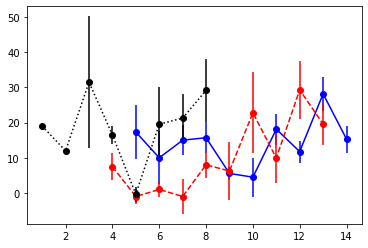

In [13]:
increment_non_insight = []
close_non_insight = []

for i in range(len(df_non_insight_filtered.index)):
    b = df_non_insight_filtered['close'].iloc[i]
    increment_non_insight.append(np.diff(b))
    close_non_insight.append(b)

n = 10
a = increment_non_insight
m = [li[::-1] for li in a]
l = [np.array(xi) for xi in m]
df_2 = pd.DataFrame(l)
y = np.flip(df_2.mean(0).values)
x = np.array(range(len(y)))+1
e = np.flip(df_2.sem(0,ddof=0).values)
c = np.flip(df_2.count(0).values)
plt.errorbar(x[-n:], y[-n:], e[-n:], linestyle='-', marker='o', color = 'blue')

increment_anagram = []
close_anagram = []
for i in range(len(df_anagram_filtered.index)):
    b = df_anagram_filtered['close'].iloc[i]
    increment_anagram.append(np.diff(b))
    close_anagram.append(b)

a = increment_anagram
m = [li[::-1] for li in a]
l = [np.array(xi) for xi in m]
df_1 = pd.DataFrame(l)
y = np.flip(df_1.mean(0).values)
x = np.array(range(len(y)))+1
e = np.flip(df_1.sem(0,ddof=0).values)
c = np.flip(df_1.count(0).values)
plt.errorbar(x[-n:], y[-n:], e[-n:], linestyle='--', marker='o', color = 'red')

increment_insight = []
close_insight = []
for i in range(len(df_insight_filtered.index)):
    b = df_insight_filtered['close'].iloc[i]
    increment_insight.append(np.diff(b))
    close_insight.append(b)

a = increment_insight
m = [li[::-1] for li in a]
l = [np.array(xi) for xi in m]
df_3 = pd.DataFrame(l)
y = np.flip(df_3.mean(0).values)
x = np.array(range(len(y)))+1
e = np.flip(df_3.sem(0,ddof=0).values)
c = np.flip(df_3.count(0).values)
plt.errorbar(x[-n:], y[-n:], e[-n:], linestyle=':', marker='o', color = 'black')


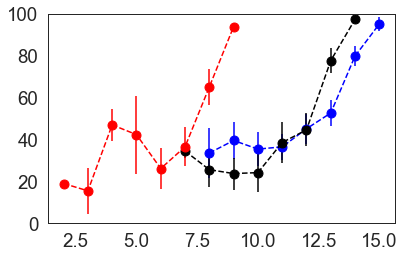

In [14]:
import seaborn as sns
sns.set(style="white", font_scale=1.7, rc={'figure.figsize':(6,4), 
                                              "grid.linewidth": 1, "axes.linewidth": 1,})

a = close_non_insight
n = 8 #how many points
m = [li[::-1] for li in a]
l = [np.array(xi) for xi in m]
non_insight_data = l
df_1 = pd.DataFrame(l)
y = np.flip(df_1.mean(0).values)
e = np.flip(df_1.sem(0,ddof=0).values)
c = np.flip(df_1.count(0).values)
x = np.array(range(len(y)))+1
plt.errorbar(x[-n:], y[-n:], e[-n:], linestyle='--', marker='o', color = 'blue', markersize=9)
plt.ylim([0,100])

a = close_anagram
m = [li[::-1] for li in a]
l = [np.array(xi) for xi in m]
df_1 = pd.DataFrame(l)
y = np.flip(df_1.mean(0).values)
e = np.flip(df_1.sem(0,ddof=0).values)
c = np.flip(df_1.count(0).values)
x = np.array(range(len(y)))+1
plt.errorbar(x[-n:], y[-n:], e[-n:], linestyle='--', marker='o', color = 'black', markersize=9)
plt.ylim([0,100])

a = close_insight
m = [li[::-1] for li in a]
l = [np.array(xi) for xi in m]
df_1 = pd.DataFrame(l)
y = np.flip(df_1.mean(0).values)
e = np.flip(df_1.sem(0,ddof=0).values)
c = np.flip(df_1.count(0).values)
x = np.array(range(len(y)))+1
plt.errorbar(x[-n:], y[-n:], e[-n:], linestyle='--', marker='o', color = 'red', markersize=9)
plt.ylim([0,100])

plt.tight_layout()

